In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sequencing_tools.viz_tools import okabeito_palette, color_encoder, simpsons_palette
from sequencing_tools.stats_tools import p_adjust
from scipy.special import ndtr
from collections import defaultdict
from sequencing_tools.fastq_tools import reverse_complement
from sequencing_tools.bam_tools import get_strand
import RNA
from multiprocessing import Pool
import random
import pysam
import glob
import re
#import genomeview
from pybedtools import BedTool
import mappy as mp
from plotting_utils import figure_path
from matplotlib import rcParams
from peak_utils import *

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [2]:
project_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map'
peak_path = project_path + '/bed_files/merged_bed/MACS2/annotated'
#peak_path = project_path + '/CLAM//BED_files/peaks/annotation'
peak_tsv = peak_path + '/unfragmented.tsv'
print(peak_tsv)
peak_df = load_peaks(peak_tsv)  \
    .assign(sense_gtype = lambda d: np.where(d.sense_gtype == ".", 'Unannotated', d.sense_gtype))\
    .assign(antisense_gtype = lambda d: np.where(d.antisense_gtype == ".", 'Unannotated', d.antisense_gtype)) \
    .sort_values('pileup', ascending=False)
peak_df.head()

/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/bed_files/merged_bed/MACS2/annotated/unfragmented.tsv


,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
0,chr1,28975111,28975251,unfragmented.fwd_peak_598,444037,8623.88574,44411.53906,44403.73438,8921.0,13,RNU11,snRNA,+,.,Unannotated,0.0,0.0,Sense
1,chr6,95156834,95156909,unfragmented.rvs_peak_21667,268947,5500.37207,26902.80469,26894.78516,6569.0,13,MTPAP,RBP,-,.,Unannotated,0.0,0.0,Sense
2,chr1,17067008,17067186,unfragmented.fwd_peak_360,115194,2508.29224,11526.93945,11519.47656,2594.0,13,RNU1-4,snRNA,+,RP5-1182A14.7,Long RNA,0.0,0.0,Sense
6,chr1,149223834,149224222,unfragmented.rvs_peak_1462,92341,2106.93115,9241.44434,9234.12695,2232.0,13,RNVU1-18,snRNA,-,.,Unannotated,0.0,0.0,Sense
3,chr14,35015918,35016096,unfragmented.fwd_peak_7919,105399,2189.04321,10547.26758,10539.96484,2220.0,13,U1,snRNA,+,.,Unannotated,0.0,0.0,Sense


In [3]:
ce = color_encoder()
colors = simpsons_palette()
#colors.extend(['black','white'])
random.seed(12)
colors = random.sample(colors, k = len(peak_df.sense_gtype.unique()))
ce.fit(peak_df.sense_gtype, colors)
ce.encoder = {'Long RNA': '#370335',
     'RBP': '#91331F',
     'Repeats': '#197EC0',
     'Unannotated': '#46732E',
     'miRNA': '#FD7446',
     'misc RNA': '#FD8CC1',
     'tRF3':'black',
     'tRF5':'black',
     'piRNA': '#D5E4A2',
     'snRNA': '#8A9197',
     'snoRNA': '#FED439'}

In [4]:
peak_df\
    .query('pileup >= %i & sample_count > %i' %(pileup_cutoff, sample_cutoff))\
    .query('sense_gtype == "Long RNA"')\
    .sort_values('pileup', ascending=False)\
    .assign(seq = lambda d: list(map(fetch_seq, d.chrom, d.start, d.end, d.strand)))\
    .assign(is_mt = lambda d: d.seq.map(is_mt))

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense,seq,is_mt
11,chr9,35657742,35658019,unfragmented.rvs_peak_25219,59130,1389.63794,5919.84961,5913.01172,1451.0,13,RMRP,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense,ACGTGGTTCGTGCTGAAGGCCTGTATCCTAGGCTACACACTGAGGA...,not_MT
12,chr14,20811226,20811574,unfragmented.rvs_peak_7180,48178,1105.20117,4824.54492,4817.82275,1129.0,13,RPPH1,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AAACTGAAATGATGAAGGTAAAAAATAAAACATCAACAATAACTAG...,not_MT
31,chr16,20733598,20733724,unfragmented.rvs_peak_9199,8114,219.87549,817.56024,811.46912,223.0,13,THUMPD1,Long RNA,-,SFPQ,RBP,0.000000e+00,0.000000e+00,Sense,GCTCTGTTAAAGTGAATTCACAGAAAAATGCATTAATCCCTCTGAA...,not_MT
34,chr9,81357659,81357730,unfragmented.rvs_peak_25392,7071,189.37199,713.23212,707.16498,191.0,13,RP11-506C15.1,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AGAGTAAGGTCAGTTAAATAAGCTAACGGGCCCATACCCCGAAAAT...,not_MT
36,chr10,101817586,101817662,unfragmented.rvs_peak_3381,6558,178.33235,661.91052,655.87775,180.0,13,CPN1,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense,aaaggaaagaaagaaagatagaaagataagaaagaagaaagaaaga...,not_MT
40,chr7,63571927,63571997,unfragmented.rvs_peak_22821,5840,159.78261,590.04108,584.05396,161.0,13,RP11-3N2.6,Long RNA,-,RP11-165H4.1,Long RNA,0.000000e+00,0.000000e+00,Sense,AAGTAAGGTCAGCTAAATAAGCTATCTGGCCCATACCCCAAAAATG...,not_MT
42,chr9,5095156,5095227,unfragmented.fwd_peak_27440,5438,151.64110,549.94501,543.88373,153.0,13,JAK2,Long RNA,+,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AAGTAAGTTCAGCTAAATAAGCTATTGGGCCCATTCTCCTGAAAAT...,not_MT
48,chr4,91759632,91760267,unfragmented.rvs_peak_18847,4596,130.07370,465.54456,459.62344,131.0,13,AC019188.1,Long RNA,-,CCSER1,Long RNA,0.000000e+00,0.000000e+00,Sense,GCTTTCTTAATCTACACTGTGATACTGTATTGATCTAAATAAATAG...,not_MT
52,chr2,140977935,140978003,unfragmented.rvs_peak_14033,4355,123.28905,441.49170,435.59653,124.0,12,AC092156.2,Long RNA,-,.,Unannotated,0.000000e+00,0.000000e+00,Sense,acacacacttgcacacacacacTGAATTCTTACTGCTCTTGCTTCC...,not_MT
61,chr13,85095787,85095865,unfragmented.fwd_peak_7549,3394,99.54677,345.38541,339.49966,100.0,13,LINC00333,Long RNA,+,.,Unannotated,0.000000e+00,0.000000e+00,Sense,GGGACAAAATACTTCTAGTTTATTGTTTTGATTGTTGGAAGGATCC...,not_MT


In [5]:
peak_df.sense_gtype.unique()

array(['snRNA', 'RBP', 'Unannotated', 'Long RNA', 'misc RNA', 'snoRNA',
       'Repeats', 'piRNA', 'miRNA'], dtype=object)

Saved: /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/peak_figure.pdf


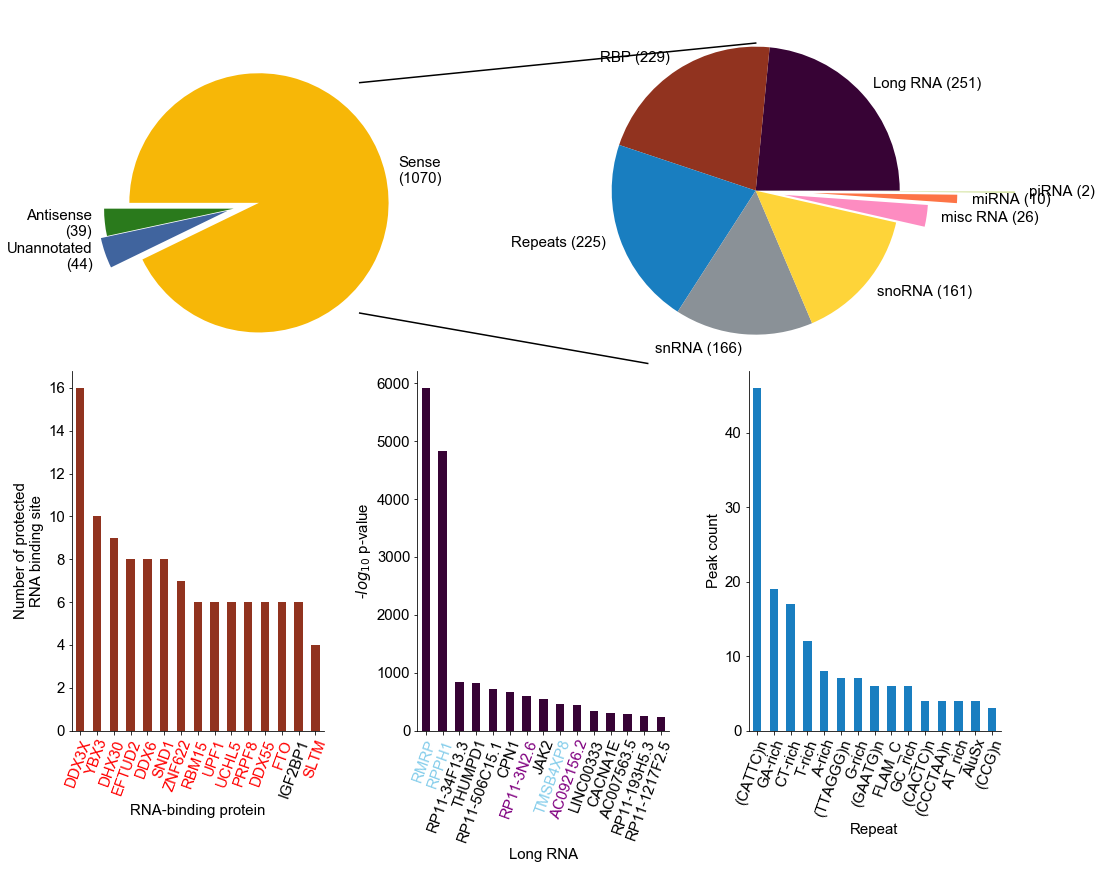

In [6]:
fig = plt.figure(figsize=(10,10))

strand_ax = fig.add_axes([-0.1, 0.5, 0.45, 0.45])
pie_ax = fig.add_axes([0.6, 0.5, 0.5, 0.5])
rbp_ax = fig.add_axes([-0.1, 0, 0.35, 0.5])
long_ax = fig.add_axes([0.38, 0, 0.35, 0.5])
misc_ax = fig.add_axes([0.84, 0, 0.35, 0.5])

top_n = 15
plot_peak_strand(peak_df, strand_ax)
sense_peaks = peak_df.query('is_sense == "Sense"')
plot_peak_pie(sense_peaks, pie_ax, ce)
plot_RNA(sense_peaks, misc_ax, ce, rnatype='Repeats', top_n = top_n)
rbp_df = plot_rbp(sense_peaks, rbp_ax, ce, top_n = top_n)
plot_long_RNA_peak(peak_df, long_ax, ce, top_n = top_n, y_val = 'log10p')
l1 = mlines.Line2D([0.3,0.85],[0.9,0.955], color= 'black',
                   figure = fig,  transform=fig.transFigure)
l2 = mlines.Line2D([0.3,0.7],[0.58,0.51], color= 'black',
                   figure = fig,  transform=fig.transFigure)
fig.lines.extend([l1, l2])
figure_name = figure_path + '/peak_figure.pdf'
fig.savefig(figure_name, bbox_inches = 'tight')
print('Saved:', figure_name)

In [14]:
import RNA 

rbp = peak_df\
    .query('sense_gtype=="Long RNA"') \
    .query('pileup >= %i & sample_count >= %i'%(pileup_cutoff, sample_cutoff))\
    .assign(seq = lambda d: list(map(fetch_seq, d.chrom, d.start, d.end, d.strand))) \
    .assign(mt = lambda d: d.seq.map(is_mt))  \
    .assign(shape = lambda d: d.seq.map(RNA.fold))\
    .assign(energy = lambda d: list(map(lambda x: x[1], d['shape'])))\
    .assign(shape = lambda d: list(map(lambda x: x[0], d['shape'])))\
    .assign(width = lambda d: d.end - d.start)\
    .sort_values('log10p', ascending=False)
rbp.head(15)

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,...,antisense_gname,antisense_gtype,pvalue,FDR,is_sense,seq,mt,shape,energy,width
11,chr9,35657742,35658019,unfragmented.rvs_peak_25219,59130,1389.63794,5919.84961,5913.01172,1451.0,13,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,ACGTGGTTCGTGCTGAAGGCCTGTATCCTAGGCTACACACTGAGGA...,not_MT,....(((.((((((((((.(((((....(((((........(((((...,-103.900002,277
12,chr14,20811226,20811574,unfragmented.rvs_peak_7180,48178,1105.20117,4824.54492,4817.82275,1129.0,13,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AAACTGAAATGATGAAGGTAAAAAATAAAACATCAACAATAACTAG...,not_MT,....(((((.((.((((((...(((((...........((((.(((...,-61.500000,348
30,chr15,68132284,68132406,unfragmented.fwd_peak_9226,8285,235.84714,834.72504,828.53333,243.0,5,...,RNU6-1,snRNA,0.000000e+00,0.000000e+00,Sense,cacacccggctactttttgtatttttagtagacatggggtttcact...,not_MT,(((.((((((((((............))))).).))))...(((((...,-35.299999,122
31,chr16,20733598,20733724,unfragmented.rvs_peak_9199,8114,219.87549,817.56024,811.46912,223.0,13,...,SFPQ,RBP,0.000000e+00,0.000000e+00,Sense,GCTCTGTTAAAGTGAATTCACAGAAAAATGCATTAATCCCTCTGAA...,not_MT,((...((((((..((((((.((((...((......))...)))).....,-16.200001,126
34,chr9,81357659,81357730,unfragmented.rvs_peak_25392,7071,189.37199,713.23212,707.16498,191.0,13,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AGAGTAAGGTCAGTTAAATAAGCTAACGGGCCCATACCCCGAAAAT...,not_MT,..(((((((..((.......((((((((((......)))..........,-11.300000,71
36,chr10,101817586,101817662,unfragmented.rvs_peak_3381,6558,178.33235,661.91052,655.87775,180.0,13,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,aaaggaaagaaagaaagatagaaagataagaaagaagaaagaaaga...,not_MT,.................................................,0.000000,76
40,chr7,63571927,63571997,unfragmented.rvs_peak_22821,5840,159.78261,590.04108,584.05396,161.0,13,...,RP11-165H4.1,Long RNA,0.000000e+00,0.000000e+00,Sense,AAGTAAGGTCAGCTAAATAAGCTATCTGGCCCATACCCCAAAAATG...,not_MT,..(((.((((((.((.......)).))))))..))).((((........,-9.500000,70
42,chr9,5095156,5095227,unfragmented.fwd_peak_27440,5438,151.64110,549.94501,543.88373,153.0,13,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AAGTAAGTTCAGCTAAATAAGCTATTGGGCCCATTCTCCTGAAAAT...,not_MT,..........((((.....))))..((((........((..........,-6.900000,71
48,chr4,91759632,91760267,unfragmented.rvs_peak_18847,4596,130.07370,465.54456,459.62344,131.0,13,...,CCSER1,Long RNA,0.000000e+00,0.000000e+00,Sense,GCTTTCTTAATCTACACTGTGATACTGTATTGATCTAAATAAATAG...,not_MT,(((........(((((((((((((...((((.(((((((((........,-116.000000,635
52,chr2,140977935,140978003,unfragmented.rvs_peak_14033,4355,123.28905,441.49170,435.59653,124.0,12,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,acacacacttgcacacacacacTGAATTCTTACTGCTCTTGCTTCC...,not_MT,....................(((((..(((((..((((...........,-6.900000,68


In [10]:
rbp.query('sense_gname == "RP11-958N24.1"')

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,...,antisense_gname,antisense_gtype,pvalue,FDR,is_sense,seq,mt,shape,energy,width
195,chr16,15027133,15027223,unfragmented.fwd_peak_10211,767,30.92256,82.08703,76.78608,31.0,10,...,.,Unannotated,8.184083e-83,2.009333e-80,Sense,GTGGGTGCCGTAGGGGTCGGGACAGCCTCTTCCTGCCCAGCCCTTC...,not_MT,(.(((.((.(.((((((.(((.(((.......)))))).))))))....,-35.5,90


In [11]:
fold = rbp.nlargest(15,'log10p').pipe(lambda d: d[~d.sense_gname.str.contains('RMRP|RPPH1|AC019188.1|HIST')])
fold

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,...,antisense_gname,antisense_gtype,pvalue,FDR,is_sense,seq,mt,shape,energy,width
24,chr2,140977935,140978004,unfragmented.rvs_peak_13679,11217,286.01276,1127.94275,1121.75208,289.0,13,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AAGTAAGGTCAGCTATAAGCTATCGGGCCCATACCCCAAAAATGTT...,not_MT,.((((.((..((((...))))...(((......))).......(.....,-9.800000,69
25,chr16,20733598,20733724,unfragmented.rvs_peak_8984,11163,303.10959,1122.53088,1116.35022,311.0,13,...,SFPQ,RBP,0.000000e+00,0.000000e+00,Sense,TAGAACTGCTAACTCATGCCACCATGTTTAATAACATGGCTTTCTC...,not_MT,.......(((((((.(((...(((((((....)))))))..........,-21.799999,126
33,chr7,63571878,63571997,unfragmented.rvs_peak_22218,7565,201.19284,762.61884,756.54669,203.0,13,...,RP11-165H4.1,Long RNA,0.000000e+00,0.000000e+00,Sense,AAGTAAGGTCAGCTAAATAAGCTATCTGGCCCATACCCCAAAAATG...,not_MT,.((((((((.((((.....))))...(((........))).....(...,-16.799999,119
38,chr9,81357559,81357730,unfragmented.rvs_peak_24696,6177,175.14711,623.77051,617.77045,178.0,12,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AGAGTAAGGTCAGTTAAATAAGCTAACGGGCCCATACCCCGAAAAT...,not_MT,..(((((((..(((..((((((.....((((.........(((......,-33.299999,171
39,chr10,101817586,101817662,unfragmented.rvs_peak_3309,6099,173.19016,615.95197,609.95935,176.0,13,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AGTTCACTGTAAAGCTAACCCAGCATTAACCTTTTAAGTTAAAGAC...,not_MT,..((((((((((.(((.....)))......((((......)))).....,-17.299999,76
45,chr9,5095156,5095227,unfragmented.fwd_peak_28079,4835,138.51602,489.52188,483.53564,140.0,13,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,AAGTAAGTTCAGCTAAATAAGCTATTGGGCCCATTCTCCTGAAAAT...,not_MT,..........((((.....))))..((((........((..........,-6.900000,71
51,chr13,85095787,85095865,unfragmented.fwd_peak_7758,4595,130.07233,465.50284,459.54266,131.0,13,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,TAATTTTTAAAGGATAAGACTTATCTGTTGGTCTTAGGAACCCAAA...,not_MT,..(((((((..((((((((((........)))))))((...))......,-8.700000,78
62,chr1,181391976,181392122,unfragmented.fwd_peak_2088,3761,111.84785,382.00964,376.11917,113.0,13,...,.,Unannotated,0.000000e+00,0.000000e+00,Sense,TGTCTACCGAGAAAGTGTACAAGAACTGCTAACTCATGCCCCCATG...,not_MT,........((((((((...((.(...(((((...((((....))))...,-26.600000,146
66,chr2,217744485,217744561,unfragmented.fwd_peak_16313,2980,92.87482,303.87170,298.06653,94.0,13,...,.,Unannotated,1.343693e-304,9.333749e-302,Sense,AACTTTTAAATAATAGAAGTAATACATTGGCCTTAAAAGCCAAGAA...,not_MT,.(((((((.....)))))))......(((((.......)))))......,-10.700000,76
87,chr7,57238479,57238685,unfragmented.fwd_peak_25649,2041,64.05077,209.81747,204.13219,64.0,13,...,GUSBP10,misc RNA,1.522404e-210,7.955610e-208,Sense,CCTGTAAATATAGTTTAATCAAAACATTAGATTGTGGGTCTAATAA...,not_MT,.........((((((((((......))))))))))((((..........,-39.400002,206


In [12]:
import random
from collections import Counter
from scipy.stats import ranksums

es = []
bases = list('ACTG')
for w, seq in zip(fold.width, fold.seq):
    b = Counter(seq.upper())
    weights = [b[n] for n in bases]
    for i in range(40):
        random_seq = ''.join(random.choices(list('ACTG'), 
                                            k=w, weights=weights))
        s, e = RNA.fold(random_seq)
        es.append(e)

In [13]:
w, p = ranksums(es, fold.energy.values)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


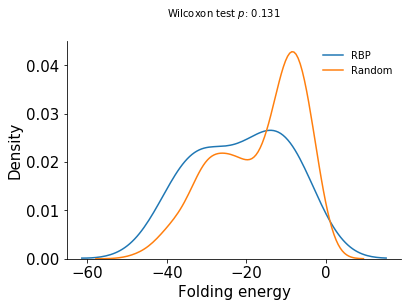

In [14]:
ax = plt.subplot()
sns.distplot(fold.energy, label = 'RBP', ax = ax, hist=False)
sns.distplot(es, label = 'Random', ax = ax, hist=False)
ax.text(-40,0.05, 'Wilcoxon test $p$: %.3f' %p)
ax.legend(frameon=False)
sns.despine()
ax.set_xlabel('Folding energy')
ax.set_ylabel('Density')
plt.savefig(figure_path + '/fold_energy.pdf', bbox_inches='tight')

In [15]:
colnames = rbp.columns.tolist()
colnames.extend(['tRNA_chrom','tRNA_start','tRNA_end','tRNA_name', 
                'tRNA_score','tRNA_strand', 'tRNA_type',
               'tRNA_id','distance'])

closest = BedTool().from_dataframe(rbp.sort_values(['chrom','start','end']))\
    .closest(b = '/stor/work/Lambowitz/ref/hg19/new_genes/tRNA.sorted.bed', d= True) \
    .to_dataframe(names = colnames) 

In [16]:
'|'.join(closest.nlargest(20, 'log10p').query('distance < 100').sense_gname)

'AC092156.2|RP11-3N2.6|JAK2|RP11-91A15.2|RP11-165H4.1'

In [17]:
RNA.fold(rbp.seq.values[2])

['.((((.((..((((...))))...(((......))).......(..((......))..))).))))...',
 -9.800000190734863]

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


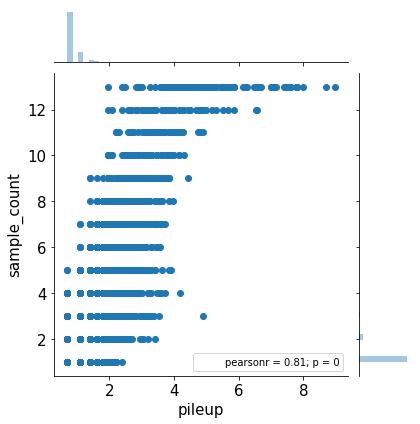

In [18]:
sns.jointplot(peak_df.pileup.transform(np.log),
            peak_df.sample_count)

In [9]:
','.join(rbp_df.head(15).index)

'UCHL5,LARP4,DHX30,EFTUD2,YBX3,XPO5,DDX6,METAP2,SND1,SRSF7,MTPAP,PCBP2,SUB1,EIF3D,TIA1'

In [10]:
peak_df\
    .query('pileup >= %i' %pileup_cutoff)\
    .to_csv(peak_path + '/peaks.tsv',sep='\t', index=False)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


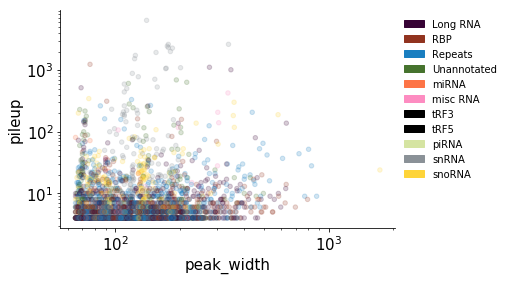

In [11]:
ax = plt.subplot()
pdf = peak_df\
    .pipe(lambda d: d[~d.sense_gtype.str.contains('tRF')])\
    .query('pileup >= %i' %pileup_cutoff)\
    .assign(peak_width = lambda d: d.end-d.start)\
    .assign(log_pile = lambda d: d.pileup.transform(np.log10))

pdf.plot.scatter('peak_width','pileup', 
                  color = ce.transform(pdf.sense_gtype), ax = ax,
                 alpha = 0.2)
ax.set_xscale('log')
ax.set_yscale('log')
ce.show_legend(ax = ax, bbox_to_anchor =(1,1), frameon=False)
sns.despine()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


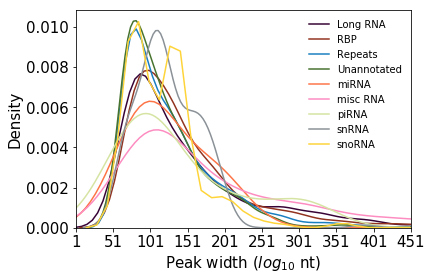

In [19]:
ax = plt.subplot()

for gt, gd in peak_df\
            .query('pileup >= %i' %(pileup_cutoff))\
            .assign(peak_width = lambda d: (d.end-d.start))\
            .groupby('sense_gtype'):
    alpha = 1 if gt in ["Long RNA"] else 1
    sns.distplot(gd.peak_width, ax = ax, kde_kws={'alpha':alpha},
                label = gt, color = ce.encoder[gt],
                hist=False)
lgd = ax.legend(frameon=False)
for lh in lgd.legendHandles: 
    lh.set_alpha(1)
ax.set_ylabel('Density')
ax.set_xlabel('Peak width ($log_{10}$ nt)')

x_range = np.arange(1,500, 50)
ax.set_xlim(x_range.min(), x_range.max())
ax.set_xticks(x_range)
for xt, x in zip(ax.get_xticklabels(), x_range):
    xt.set_text(r'$10^{%s}$' %(x))

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Plotted:  /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/peak_qc.pdf


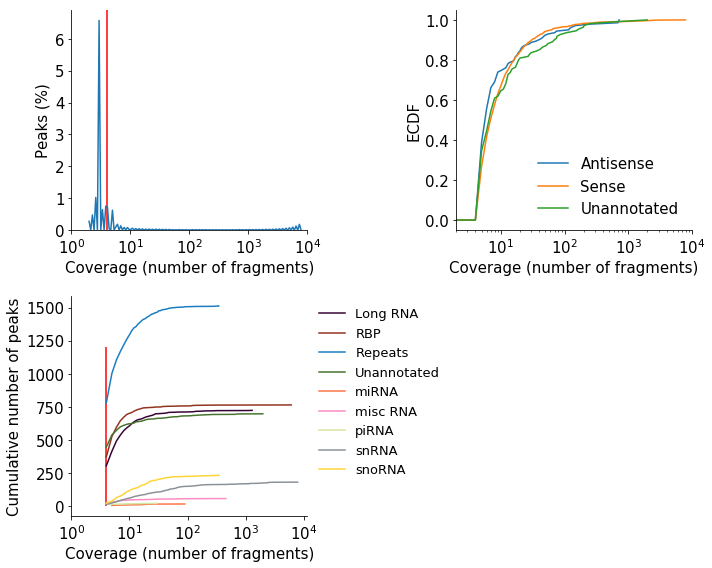

In [20]:
fig = plt.figure(figsize=(10,8))
cov_ax = fig.add_subplot(221)
number_ax = fig.add_subplot(223)
dist_cov_ax = fig.add_subplot(222)
#peak_annotation_ax = fig.add_subplot(224)

plot_peak_coverage(peak_df, cov_ax, log=True)
#plot_cov_density(peak_df, dist_cov_ax)
plot_peak_cum_cov(peak_df, dist_cov_ax)
plot_peak_number(peak_df, number_ax, ce)
#### add hepG2
#combined_peaks = pd.concat([peak_df.assign(annotation = 'K562'),
#                        hep_peak_df.assign(annotation = 'K562 + HepG2')])
#plot_peak_bar(peak_annotation_ax, combined_peaks)
fig.tight_layout()

figurename = figure_path + '/peak_qc.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)

In [ ]:
lR_peak = peak_df[peak_df.sense_gtype.str.contains('Long RNA')] \
    .sort_values('log10p', ascending=False) 
lR_peak.head(20)

In [ ]:
anti_peaks.antisense_gtype.unique()

In [ ]:
anti_peaks = peak_df.query('is_sense == "Antisense"')\
    .pipe(lambda d: d[~d.antisense_gtype.str.contains('tRF')])

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0.1,0.4,0.8])
plot_peak_pie(anti_peaks, ax, ce, gtype='antisense_gtype')
ax = fig.add_axes([0.7, 0, 0.4, 1])
anti_plot = anti_peaks.nlargest(15, 'log10p')
anti_plot.plot\
    .bar('antisense_gname', 'log10p', 
         color = ce.transform(anti_plot\
                               .antisense_gtype),
        ax = ax)
ax.legend().set_visible(False)
ax.set_xlabel('RNA type')
ax.set_ylabel('-$log_{10}$ p-value')
sns.despine()
fig.tight_layout()
figurename = figure_path + '/peak_anti.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)

In [ ]:
bam_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/merged_bam'
ref_path = '/stor/work/Lambowitz/ref/hg19'
tracks = {'DNase I': bam_path + '/unfragmented.bam',
         'NaOH': bam_path + '/alkaline_hydrolysis.bam',
         'sncRNA': ref_path + '/new_genes/sncRNA_viz.bed',
         'Protein': ref_path + '/new_genes/genes.bed12.bed'}
genome = ref_path + '/genome/hg19_genome.fa'

def color_func(interval):
    return 'salmon' if get_strand(interval.read) == '+' else 'steelblue'

regions = 'chr14:50329268-50329569'
matches = re.search('(chr[0-9XY]+):([0-9]+)-([0-9]+)', regions)
chrom, start, end = matches.groups()

viz = genomeview.visualize_data(tracks, chrom, int(start)-400, int(end)+400, genome)
for track in ['DNase I', 'NaOH']:
    tr = genomeview.get_one_track(viz, track)
    tr.color_fn = color_func
    if track == "DNase I":
        tr.row_height = 0.02

viz

In [ ]:
fa = pysam.FastaFile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
fa.fetch('chr12',22158771,22158870)

In [ ]:
columns = peak_df.columns
columns = np.append(columns,['intron_chrom','intron_start','intron_end',
               'intron_gene','intron_score','intron_strand'])
intron_df = BedTool()\
    .from_dataframe(peak_df )\
    .intersect('/stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed', 
               f= 0.8,F=0.8,wb=True)\
    .to_dataframe(names = columns)
intron_df.shape

In [ ]:
intron_df \
    .query('pileup >= 5' )

In [ ]:
ss_dinucleotide = defaultdict(int)
ss_dinucleotide_seq = defaultdict(list)
seqs = []
fa = pysam.Fastafile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
def fetch_seq(chrom, start, end, strand):
    intron_seq = fa.fetch(chrom, start - 1, end)
    intron_seq = intron_seq if strand == "+" else reverse_complement(intron_seq)
    return intron_seq
    
    

intron_df = intron_df.query('pileup >=3') \
    .assign(seq = lambda d: list(map(fetch_seq, d.chrom, d.start, d.end, d.strand))) \
    .assign(dinucleotide = lambda d: d.seq.str.slice(0,2) + ':' + (d.seq + 'N').str.slice(-3,-1))
intron_df.head()

In [ ]:
tablename = figure_path + '/intron_table.csv'
intron_df \
    .filter(regex='chrom|start|end|log10|pileup|intron_gene|seq') \
    .sort_values('pileup', ascending=False)\
    .to_csv(tablename, index=False)
print('Written: ', tablename)

In [ ]:
intron_df.query('pileup >= %i' %pileup_cutoff) \
    .assign(length = lambda d: d.end - d.start) \
    .describe()

In [ ]:
%load_ext autoreload
%autoreload 2
import mygene as mg
import gseapy as gsp
mgi = mg.MyGeneInfo()

glist = intron_df.query('pileup >= %i' %pileup_cutoff) \
    .filter(['pileup','gid']) \
    .assign(ensg = lambda d: d.gid.str.extract('(ENSG[0-9]+)')) \
    .assign(symbol = lambda d: list(map(lambda x: x['symbol'], mgi.getgenes(d.ensg))))

In [ ]:
glist

In [ ]:
%tb
rnk = glist\
    .filter(['symbol','pileup']) \
    .pipe(lambda d: d[~d.symbol.str.contains('^AC')])\
    .rename(columns={'symbol':'gene_name'})
#res = gsp.prerank(rnk = rnk, gene_sets='/stor/work/Lambowitz/ref/gene_sets/c2.all.v6.2.symbols.gmt')
print('\n'.join(rnk.gene_name.tolist()))



In [ ]:
peaks\
    .query('merged_type == "miRNA"')\
    .filter(regex='log10p|picked_RNA_sense')\
    .set_index('picked_RNA_sense')\
    .nlargest(10, 'log10p')\
    .plot.bar() 

In [ ]:
peaks.pipe(lambda d: d[d.picked_RNA_sense.str.contains("CGGA")])

In [ ]:
peaks\
    .assign(anti_merged_type = lambda d: d.picked_type_anti.map(merge_type)) \
    .query('merged_type == "Repeats" | (anti_merged_type == "Repeats" & is_sense != "Sense")')

In [ ]:
peaks\
    .query('merged_type=="RBP"')\
    .pipe(lambda d: d[~d.gtype.str.contains(lrna_regex)])

In [ ]:
import gseapy as gsp

In [ ]:
res = gsp.prerank(rnk = rbp_df.sort_values(0,ascending=False),
           gene_sets = 'KEGG_2016')

In [ ]:
res.res2d

In [ ]:
aligner = mp.Aligner('/stor/work/Lambowitz/ref/hg19/genome/chrM.minimap2_idx', preset='sr')
aln = aligner.map(fa.fetch('chr17',33981908,33982067))

In [ ]:
print(next(aln))

In [ ]:
def check_MT(peaks, return_column=False):
    mt = 0
    aligner = mp.Aligner('/stor/work/Lambowitz/ref/hg19/genome/chrM.minimap2_idx', preset='sr')
    fa = pysam.FastaFile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
    mts = []
    for peak_count, row in peaks.reset_index().iterrows():
        seq = fa.fetch(row['chrom'], row['start'], row['end'])
        seq = seq if row['strand'] == "+" else reverse_complement(seq)
    
        alns = aligner.map(seq)
        try:
            aln = next(alns)
            mt += 1
            mts.append('MT')
            #print(aln.cigar_str)
        except StopIteration:
            #print(row)
            mts.append('no')
            pass


    print('%i seq: %i in MT' %(peak_count, mt))
    if return_column:
        return mts

In [ ]:
anti = peak_df.query('pileup >= 5').query('is_sense == "Unannotated"')
anti['MT'] = check_MT(anti, return_column=True)

In [ ]:
peak_df.query("sense_gtype == 'tRF3'")